# OpenMax를 적용해 정위치 주차여부 판단하자!

주차된 차의 블랙박스로 찍힌 이미지를 이용해서 차가 쏘카존의 정위치에 주차되었는지 아닌지를 판별해보자.

단순히 주자창마다의 정위치로 분류를 해버리면 새로운 이미지가 들어왔을 때 제대로 판별이 되지않느다.  
그래서 현재의 이미지 판별은 Open Set Recognition문제에 해당한다.  
Open Set Recognition 문제를 해결하기 위한 방법 중 초기에 등장한 OpenMax라는 기법을 사용해보자.

## 0. 모듈 import

In [ ]:
import os
import numpy as np
from tqdm import tqdm
from statistics import mean

import torch
import torchvision

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from scipy import stats

from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## 1. 데이터 준비

In [ ]:
PROJECT_PATH = os.getenv('HOME') + '/aiffel/socar_open_set'
MODEL_PATH = os.path.join(PROJECT_PATH, 'weights')
DATA_PATH = os.path.join(PROJECT_PATH, 'data')
TRAIN_PATH = os.path.join(DATA_PATH, 'train')
TEST_PATH = os.path.join(DATA_PATH, 'test')
REJECT_PATH = os.path.join(DATA_PATH, 'reject')

준비된 데이터에는 4곳의 쏘카존이 존재하므로 각 쏘카존에서 2장씩 불러와 출력해보자.

In [ ]:
images = []
labels = []

for dirpath, dirnames, filenames in os.walk(TRAIN_PATH):
    label_name = os.path.basename(dirpath)
    for i, filename in enumerate(filenames):
        if i >= 2:
            break
        images.append(Image.open(os.path.join(dirpath, filename)))
        labels.append(os.path.basename(dirpath))

def show_samples(images, labels):
    fig, _ = plt.subplots(4, 2, figsize=(14, 22))
    for ax, img, label in zip(fig.axes, images, labels):
        ax.imshow(img)
        ax.set_title(label)
    plt.show()
    
show_samples(images, labels)

![xu101606815470_590562362](https://user-images.githubusercontent.com/15683086/147848965-db928429-bbd0-4d6d-ba1e-3f4c11eba4eb.jpg)

 대체용 이미지 <출처: https://www.bobaedream.co.kr/>

기존에는 리사이즈 후에 중간부분을 잘라서 랜덤하게 좌/우반전, 상/하반전을 주는 전처리작업을 하였다.  
여기에 의문이 있는 부분에 대하여 Ablation study를 해보았다.

이미지가 1920 * 1080으로 매우 크고, 이미지의 위에는 블랙박스의 UI로 글자가 있고,  
블랙박스 특성상 밑에 부분에도 차의 보넷으로 판별에 방해가 되는 부분이 있다.  
여기에 굳이 기존에 방법에서 좌/우 이미지를 자르지 않고 상/하만 짤라서 학습시켜보았지만,  
기존의 좌/우 상/하를 모두 짤랐을 때보다 오히려 성능이 떨어졌다.  
예상으로는 이미지의 양옆이 카메라의 특성으로 생긴 굴곡으로 오히려 문제가 되는것 같다.  

두번째로 이미지들이 모두 상/하가 정해져 있기 때문에 상/하 반전을 시키지 않고 학습시켰을 경우,  
확실히 train데이터에 대해서는 성능이 올라갔지만, 오히려 test데이터에 대해서 성능이 떨어졌다.  
이전에 봤던 https://arxiv.org/abs/1803.07728 논문의 원리처럼 기존의 이미지를 방향이 바뀐 이미지를  
알아맞추도록 학습되면서 이미지 자체의 특성을 더 잘 추출하게 되는것이 아닌가 싶다.  

결국 이래저래 실험해봤지만, 기존의 방법대로 전처리를 하는것이 성능이 가장좋았다.  
위의 샘플로 출력한 이미지들에 대해서 전처리 과정을 거쳐서 출력해보자.

In [ ]:
nearest_mode = torchvision.transforms.InterpolationMode.NEAREST
sample_transformer = torchvision.transforms.Compose([
    torchvision.transforms.Resize((320, 320), interpolation=nearest_mode),
    torchvision.transforms.CenterCrop((224,224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomVerticalFlip(),
    torchvision.transforms.ColorJitter(),
])

trans_images = [sample_transformer(img) for img in images]
show_samples(trans_images, labels)

![2](https://user-images.githubusercontent.com/15683086/147849001-3c9216bb-facc-4c99-84f6-f9e92a64e486.jpg)


대체용 이미지

판별에 방해가 되던 블랙박스 글자가 사라지고, 224 * 224의 크기에 반전도 잘되었다.

다음으로 정위치에 주차되지않은 경우들의 이미지들, Open Set Recognition에서 기존의  
분류에 속하지 않는 Unknown 데이터에 해당하는 이미지들이다.  
몇장을 샘플로 출력해보자.

In [ ]:
fig, _ = plt.subplots(2, 3, figsize=(20,8))
for dirpath, dirnames, filenames in os.walk(REJECT_PATH):
    for ax, filename in zip(fig.axes, filenames):
        image = Image.open(os.path.join(dirpath, filename), 'r')
        ax.set_title(f'size: ({image.width}, {image.height}, {image.getbands()})')
        ax.imshow(image)
        
plt.show()

우선 준비된 train/test 이미지들로 데이터셋을 만들어보자.

In [ ]:
def create_dataloader(path, batch_size, istrain):
    nearest_mode = torchvision.transforms.InterpolationMode.NEAREST
    normalize = torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
    )
    train_transformer = torchvision.transforms.Compose([
        torchvision.transforms.Resize((320,320), interpolation=nearest_mode),
        torchvision.transforms.CenterCrop((224,224)),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.RandomVerticalFlip(),
        torchvision.transforms.ColorJitter(),
        torchvision.transforms.ToTensor(),
        normalize
    ])

    test_transformer = torchvision.transforms.Compose([
        torchvision.transforms.Resize((320,320), interpolation=nearest_mode),
        torchvision.transforms.CenterCrop((224,224)),
        torchvision.transforms.ToTensor(),
        normalize
    ])
    
    if istrain:
        data = torchvision.datasets.ImageFolder(path, transform=train_transformer)
        dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
        
    else:
        data = torchvision.datasets.ImageFolder(path, transform=test_transformer)
        dataloader = torch.utils.data.DataLoader(data, shuffle=False)

    return dataloader, data

In [ ]:
BATCH_SIZE = 64

train_loader, _train_data = create_dataloader(TRAIN_PATH, BATCH_SIZE, True)
target_class_num = len(os.listdir(os.path.join(TRAIN_PATH)))

print('target_class_num: ', target_class_num)
print('train: ', _train_data.class_to_idx)

target_class_num:  4
train:  {'atower_b5': 0, 'balsan_b5': 1, 'balsan_b6': 2, 'dcube_b6': 3}


In [ ]:
for dirpath, dirnames, filenames in os.walk(TRAIN_PATH):
    if len(filenames) > 0:
        print(f'{os.path.basename(dirpath)} : {len(filenames)}')

balsan_b6 : 1250
atower_b5 : 1250
balsan_b5 : 1250
dcube_b6 : 1250


각 라벨마다 1250개 씩 총 5000개의 학습데이터가 있다.

In [ ]:
test_loader, _test_data = create_dataloader(TEST_PATH, BATCH_SIZE, False)
print('test: ', _test_data.class_to_idx)

test:  {'atower_b5': 0, 'balsan_b5': 1, 'balsan_b6': 2, 'dcube_b6': 3}


In [ ]:
for dirpath, dirnames, filenames in os.walk(TEST_PATH):
    if len(filenames) > 0:
        print(f'{os.path.basename(dirpath)} : {len(filenames)}')

balsan_b6 : 250
atower_b5 : 250
balsan_b5 : 250
dcube_b6 : 250


250개씩 총 1000개의 테스트데이터가 있다.

## 2. 모델 훈련

OpenMax 첫번째 단계로 기존 이미지들에 대한 Activation Vector를 얻어야한다.  
Activation Vector는 일반적인 딥러닝 분류를 통해 학습된 모델의 마지막 출력에서  
softmax를 통과하기 전의 라벨 개수 만큼의 차원을 가지는 벡터를 의미한다.

따라서 기존 이미지의 특성을 잘 나타내는 Activation Vector을 얻기 위해서는  
일반적인 closed set의 이미지 분류로 방법으로 모델을 학습시켜야한다.  

이미지넷으로 pretrained된 resnet50모델을 사용해서 tranfer learning을 사용한다.  
출력은 학습데이터의 라벨종류와 같은 4개이다.

In [ ]:
net = torchvision.models.resnet50(pretrained=True)
net.fc = torch.nn.Linear(
    net.fc.in_features,
    target_class_num
)

net.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
def calculate_metrics(trues, preds):
    accuracy = accuracy_score(trues, preds)
    f1 = f1_score(trues, preds, average='macro')
    precision = precision_score(trues, preds, average='macro')
    recall = recall_score(trues, preds, average='macro')
    return accuracy, f1, precision, recall

In [ ]:
def train(dataloader, net, learning_rate, weight_decay_level, device):
    
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(
        net.parameters(),
        lr = learning_rate, 
        weight_decay = weight_decay_level
    )

    net.train()

    train_losses = list()
    train_preds = list()
    train_trues = list()

    for idx, (img, label) in enumerate(dataloader):
        img = img.to(device)
        label = label.to(device)
        
        optimizer.zero_grad()

        out = net(img)

        _, pred = torch.max(out, 1)
        loss = criterion(out, label)

        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        train_trues.extend(label.view(-1).cpu().numpy().tolist())
        train_preds.extend(pred.view(-1).cpu().detach().numpy().tolist())

    acc, f1, prec, rec = calculate_metrics(train_trues, train_preds)

    print('\n''====== Training Metrics ======')
    print('Loss: ', mean(train_losses))
    print('Acc: ', acc)
    print('F1: ', f1)
    print('Precision: ', prec)
    print('Recall: ', rec)
    print(confusion_matrix(train_trues, train_preds))

    return net, acc, f1, prec, rec

In [ ]:
def test(dataloader, net, device):

    criterion = torch.nn.CrossEntropyLoss()
    
    net.eval()
    test_losses = list()
    test_trues = list()
    test_preds = list()
    
    with torch.no_grad():
        for idx, (img, label) in enumerate(dataloader):
            img = img.to(device)
            label = label.to(device)

            out = net(img)

            _, pred = torch.max(out, 1)
            loss = criterion(out, label)

            test_losses.append(loss.item())
            test_trues.extend(label.view(-1).cpu().numpy().tolist())
            test_preds.extend(pred.view(-1).cpu().detach().numpy().tolist())

    acc, f1, prec, rec = calculate_metrics(test_trues, test_preds)

    print('====== Test Metrics ======')
    print('Test Loss: ', mean(test_losses))
    print('Test Acc: ', acc)
    print('Test F1: ', f1)
    print('Test Precision: ', prec)
    print('Test Recall: ', rec)
    print(confusion_matrix(test_trues, test_preds))

    return net, acc, f1, prec, rec

In [ ]:
def train_classifier(net, train_loader, test_loader, n_epochs, learning_rate, weight_decay, device):
    best_test_acc = 0
    
    model_save_path = None
    model_save_base = 'weights4'
    if not os.path.exists(model_save_base):
        os.makedirs(model_save_base)
    
    print('>> Start Training Model!')
    for epoch in range(n_epochs):
        print('> epoch: ', epoch)

        net, _, _, _, _ = train(train_loader, net, learning_rate, weight_decay, device)
        net, test_acc, _, _, _  = test(test_loader, net, device)

        if test_acc > best_test_acc:

            best_test_acc = test_acc
            test_acc_str = '%.5f' % test_acc

            print('[Notification] Best Model Updated!')
            model_save_path = os.path.join(model_save_base, 'classifier_acc_' + str(test_acc_str) + '.pth') 
            torch.save(net.state_dict(), model_save_path)
                
    return model_save_path

In [ ]:
EPOCHS = 20
LEARNING_RATE = 0.005
WEIGHT_DECAY = 0.0005

saved_weight_path = train_classifier(net, train_loader, test_loader, EPOCHS, LEARNING_RATE, WEIGHT_DECAY, device)

>> Start Training Model!
> epoch:  0


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)



====== Training Metrics ======
Loss:  0.9447447253933435
Acc:  0.5842
F1:  0.5808838417128303
Precision:  0.5970113380982228
Recall:  0.5841999999999999
[[918 157  28 147]
 [ 49 665 267 269]
 [ 47 498 419 286]
 [ 47 181 103 919]]
====== Test Metrics ======
Test Loss:  2.367547545911125
Test Acc:  0.412
Test F1:  0.32982128136807104
Test Precision:  0.5324981954913623
Test Recall:  0.41200000000000003
[[ 31  18  22 179]
 [  0 115   8 127]
 [  0 171  16  63]
 [  0   0   0 250]]
[Notification] Best Model Updated!
> epoch:  1

====== Training Metrics ======
Loss:  0.47590120438533495
Acc:  0.7678
F1:  0.7674182311659401
Precision:  0.7672194664268897
Recall:  0.7678
[[1181   19    7   43]
 [  20  699  475   56]
 [   8  440  795    7]
 [  27   51    8 1164]]


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


====== Test Metrics ======
Test Loss:  2.617554460987449
Test Acc:  0.298
Test F1:  0.19145340939734584
Test Precision:  0.3645055583208893
Test Recall:  0.29800000000000004
[[  0   4 246   0]
 [  0  29 221   0]
 [  0   0 250   0]
 [  0 213  18  19]]
> epoch:  2

====== Training Metrics ======
Loss:  0.31870494405680067
Acc:  0.8768
F1:  0.8756299428982298
Precision:  0.8784908196476662
Recall:  0.8767999999999999
[[1205   15   12   18]
 [  16  883  297   54]
 [   3  130 1112    5]
 [  12   47    7 1184]]
====== Test Metrics ======
Test Loss:  1.648326583189957
Test Acc:  0.602
Test F1:  0.586790565693404
Test Precision:  0.7742125747059958
Test Recall:  0.6020000000000001
[[250   0   0   0]
 [144  68  26  12]
 [160   2  88   0]
 [ 54   0   0 196]]
[Notification] Best Model Updated!
> epoch:  3

====== Training Metrics ======
Loss:  0.17789588274457788
Acc:  0.9386
F1:  0.9382532209759239
Precision:  0.9389103886409715
Recall:  0.9386000000000001
[[1221    4    6   19]
 [  10 1077  119


====== Training Metrics ======
Loss:  0.05382690426769749
Acc:  0.9852
F1:  0.9852000000000001
Precision:  0.9852000000000001
Recall:  0.9852000000000001
[[1238    1    4    7]
 [   2 1226   19    3]
 [   7   19 1223    1]
 [   3    4    4 1239]]
====== Test Metrics ======
Test Loss:  0.07015213928533161
Test Acc:  0.976
Test F1:  0.9758328366659376
Test Precision:  0.9771281263712155
Test Recall:  0.976
[[248   0   2   0]
 [  0 229   7  14]
 [  0   0 249   1]
 [  0   0   0 250]]
> epoch:  19

====== Training Metrics ======
Loss:  0.042509753096412535
Acc:  0.9904
F1:  0.9904036637413227
Precision:  0.9904108196027105
Recall:  0.9904000000000001
[[1242    0    4    4]
 [   0 1236   12    2]
 [   2   13 1235    0]
 [   5    4    2 1239]]
====== Test Metrics ======
Test Loss:  0.22933309419060183
Test Acc:  0.914
Test F1:  0.91541106743202
Test Precision:  0.92595838069976
Test Recall:  0.9139999999999999
[[219   0  29   2]
 [  0 215  35   0]
 [  0   0 250   0]
 [  0  19   1 230]]


In [ ]:
#saved_weight_path = 'weights4/classifier_acc_0.99300.pth'
saved_weight_path = os.path.join(MODEL_PATH, 'classifier_acc_0.96008.pth')
net.load_state_dict(torch.load(saved_weight_path, map_location=device))
net.eval()

net.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## 3. Activation Vector 추출

미리 학습된 모델을 이용해서 Activation Vector를 추출해보자.  
현재의 학습 데이터는 여러 augmentation을 거친 데이터이기 때문에 새롭게 만들어준다.

In [ ]:
train_loader, _train_data = create_dataloader(TRAIN_PATH, 1, False)

augmentation을 거치지 않은 데이터를 모델의 출력인 activation vector로 만들어서 리스트에 저장한다.

In [ ]:
train_preds = list()
train_actvecs = list()
train_outputs_softmax = list()
train_labels = list()

with torch.no_grad():
  for idx, (img, label) in enumerate(train_loader):
      img = img.to(device)
      label = label.to(device)

      out = net(img)
      out_actvec = out.cpu().detach().numpy()[0]
      out_softmax = torch.softmax(out, 1).cpu().detach().numpy()[0]
      out_pred = int(torch.argmax(out).cpu().detach().numpy())
      out_label = int(label.cpu().detach().numpy())

      train_actvecs.append(out_actvec) # component 1: softmax 전의 Activation Vector
      train_preds.append(out_pred) # componenet 2: 각 데이터에 대한 예측값
      train_outputs_softmax.append(out_softmax) # component 3: 각 데이터에 대한 softmax 확률
      train_labels.append(out_label) # component 4: 각 데이터에 대한 Label (정답)

train_actvecs = np.asarray(train_actvecs)
train_preds = np.asarray(train_preds)
train_outputs_softmax = np.asarray(train_outputs_softmax)
train_labels = np.asarray(train_labels)

OpenMax는 정답을 맞힌 ativation vector를 사용한다.  
만들아진 activation vector 리스트의 정보를 확인해보자.

In [ ]:
train_correct_actvecs = train_actvecs[train_labels==train_preds]
train_correct_labels = train_labels[train_labels==train_preds]
print('Activation vector: ', train_correct_actvecs.shape)
print('Labels: ', train_correct_labels.shape)

Activation vector:  (4790, 4)
Labels:  (4790,)


최종적으로 4개의 차원을 가진 4790의 activation vector가 만들어졌다.

## 4. 베이불 분포의 모수 계산

다음으로 각 클래스 별 Activation Vector의 평균 계산한다.  
그리고 각 Activation Vector별 평균으로부터 가장 먼 100개의 Vector를 이용해  
베이불 분포의 모수를 추출한다.

In [ ]:
class_means = list()
dist_to_means = list()
mr_models = {}

for class_idx in np.unique(train_labels):
    
    print('class_idx: ', class_idx)
    class_act_vec = train_correct_actvecs[train_correct_labels==class_idx]
    print(class_act_vec.shape)
    
    class_mean = class_act_vec.mean(axis=0)
    class_means.append(class_mean)
    
    dist_to_mean = np.square(class_act_vec - class_mean).sum(axis=1) # 각 activation vector의 거리를 계산
    dist_to_mean_sorted = np.sort(dist_to_mean).astype(np.float64) # 거리를 기준으로 오름차순 정렬
    dist_to_means.append(dist_to_mean_sorted)

    shape, loc, scale = stats.weibull_max.fit(dist_to_mean[-100:]) # 거리가 가장 먼 100개를 사용하여 모수 추출
    
    mr_models[str(class_idx)] = {
        'shape':shape,
        'loc':loc,
        'scale':scale
    }
    
class_means = np.asarray(class_means)

class_idx:  0
(1250, 4)
class_idx:  1
(1170, 4)
class_idx:  2
(1179, 4)
class_idx:  3
(1191, 4)


## 5. OpenMax 적용

베이불 분포가 높다는 것은 평범하지 않다는 말이고, 이것는 주차 위치가 오위치에 있다는 뜻이다.  
베이불 분포로부터 이미지의 확률을 계산하고 그걸 통해 기존 클래스에 포함 되지 않는  
reject 클래스로 분류할 수 있다. 

In [ ]:
def compute_openmax(actvec, class_means, mr_models):
    dist_to_mean = np.square(actvec - class_means).sum(axis=1)

    scores = list()
    for class_idx in range(len(class_means)):
        params = mr_models[str(class_idx)]
        score = stats.weibull_max.cdf(
            dist_to_mean[class_idx],
            params['shape'],
            params['loc'],
            params['scale']
        )
        scores.append(score)
    scores = np.asarray(scores)
    
    weight_on_actvec = 1 - scores # 각 class별 가중치
    rev_actvec = np.concatenate([
        weight_on_actvec * actvec, # known class에 대한 가중치 곱
        [((1-weight_on_actvec) * actvec).sum()] # unknown class에 새로운 계산식
    ])
    
    openmax_prob = np.exp(rev_actvec) / np.exp(rev_actvec).sum()
    return openmax_prob

위의 함수를 통해 reject에 포함될 확률을 구했지만, 계산한 최대 확률이  
모두 다 낮은 경우라면 강제로 reject클래스로 분류해주는 과정이 필요하다.

다음ㄴ 지정된 threshold 값 보다 작은 경우는 reject클래스로 분류해주는 함수이다.

In [ ]:
def inference(actvec, threshold, target_class_num, class_means, mr_models):
    openmax_prob = compute_openmax(actvec, class_means, mr_models)
    openmax_softmax = np.exp(openmax_prob)/sum(np.exp(openmax_prob))

    pred = np.argmax(openmax_softmax)
    if np.max(openmax_softmax) < threshold:
        pred = target_class_num
    return pred

In [ ]:
def inference_dataloader(net, data_loader, threshold, target_class_num, class_means, mr_models, is_reject=False):
    result_preds = list()
    result_labels = list()

    with torch.no_grad():
      for idx, (img, label) in enumerate(data_loader):
          img = img.to(device)
          label = label.to(device)

          out = net(img)
          out_actvec = out.cpu().detach().numpy()[0]
          out_softmax = torch.softmax(out, 1).cpu().detach().numpy()[0]
          out_label = int(label.cpu().detach().numpy())

          pred = inference(out_actvec, threshold, target_class_num, class_means, mr_models)
      
          result_preds.append(pred)
          if is_reject:
              result_labels.append(target_class_num)
          else:
              result_labels.append(out_label)

    return result_preds, result_labels

## 6. Threshold에 따른 추이를 살펴보자

이제 Threshold값을 변경하면서 test와 reject데이터에 대한 성능을 알아보자.

In [ ]:
test_loader, _test_data = create_dataloader(TEST_PATH, 1, False)
reject_loader, _reject_data = create_dataloader(REJECT_PATH, 1, False)

정해진 범위의 threshold 서치를 통해서 정위치 데이터인 test 데이터와   
오위치 데이터인 reject 데이터의 정확도를 비교해보자.

In [ ]:
def threshold_search(search_list):
    test_predictions = []
    reject_predictions = []

    for threshold in search_list:
        test_preds, test_labels = inference_dataloader(
            net, test_loader, threshold, target_class_num, class_means, mr_models)
        reject_preds, reject_labels = inference_dataloader(
            net, reject_loader, threshold, target_class_num, class_means, mr_models, is_reject=True)
        test_predictions.append(accuracy_score(test_labels, test_preds))
        reject_predictions.append(accuracy_score(reject_labels, reject_preds))

    return test_predictions, reject_predictions

In [ ]:
search_list = [x * 0.01 for x in range(20, 51, 5)]

test_predictions, reject_predictions = threshold_search(search_list)

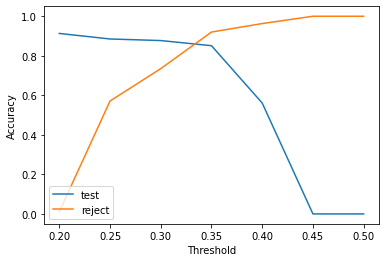

In [ ]:
plt.plot(search_list, test_predictions)
plt.plot(search_list, reject_predictions)
plt.ylabel('Accuracy')
plt.xlabel('Threshold')
plt.legend(['test', 'reject'], loc='lower left')
plt.show()

당연하게 threshold 값이 커지면서 정위치에서 평균에서 거리는가 있는 데이터들이  
오위치로 분류되면서 정확도가 떨어지고, 반대로 reject는 커지고 있다.

여기서 정위치에 대한 정확도와 오위치에 대한 정확도가 모두 높은 값을 나타내는  
threshold는 0.35정도로 보인다.

In [ ]:
test_preds, test_labels = inference_dataloader(net, test_loader, 0.35, target_class_num, class_means, mr_models)
reject_preds, reject_labels = inference_dataloader(net, reject_loader, 0.35, target_class_num, class_means, mr_models, is_reject=True)

print('Test Accuracy: ', accuracy_score(test_labels, test_preds))
print('Reject Accuracy: ', accuracy_score(reject_labels, reject_preds))

Test Accuracy:  0.851
Reject Accuracy:  0.92


## 7. 회고

이번 프로젝트를 하면서 처음으로 Open Set Recognition이라는 것을 알았다.  
생각해보면 현실은 항상 정해져 있는 답에 속하는 데이터만 들어온다는 것보다  
기존에 없던 데이터가 추가로 들어오는 상황이 훨씬 많을 것이다.  

특히 이번 프로젝트를 하면서 보통 모델의 softmax를 하기전의 마지막 출력이  
단순하게 그 값들에 대한 스코어 이기도 하지만 Activation Vector로 활용될 수  
있다는 것에서 여러가지 인사이트를 얻은 것 같다.